In [101]:
# Import libraries
from textblob import TextBlob
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Parameters 
n = 50 #the # of article headlines displayed per ticker
tickers = ['AAPL']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [102]:
# Get Data
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass



Recent News Headlines for AAPL: 
Dow Jones Rallies As J&J Jumps On Breakup Plans; Tesla Falls, Rivian Races Higher ( Nov-12-21 09:49AM )
Apple Is No Longer the World's Most Valuable Company ( 09:41AM )
5 Dow Jones Stocks To Buy And Watch In November 2021: Apple Tests Key Support Level ( 09:37AM )
After $500 Billion Rout, Optimism Grows for China: Tech Watch ( 08:09AM )
Why The Trade Desk Stock Is Skyrocketing This Week ( 08:00AM )
As Apple privacy change hinders Facebook and others, its own ad business stands to benefit ( 07:05AM )
3 Dividend-Paying Tech Stocks to Buy in November ( 06:50AM )
Zacks Value Trader Highlights: Berkshire Hathaway, VOO, Apple, Bank of America and QQQ ( 06:30AM )
Mitch Rubins RiverPark Advisors Portfolio: Top 10 Stock Picks ( 05:27AM )
Apple Partner Hon Hais Profit Tops Estimates on New iPhones ( 04:05AM )
U.S. Companies Face New Risks in a Changing China. What That Means for the Stocks. ( 04:00AM )
Jamf Holding Corp. (JAMF) Q3 2021 Earnings Call Transcript 

In [103]:
# Iterate through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])

In [104]:

analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

In [105]:
# View Data 
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)



              Date     Time    neg    neu    pos  compound
Ticker                                                    
AAPL    2021-11-12  09:49AM  0.000  1.000  0.000    0.0000
AAPL    2021-11-12  09:41AM  0.175  0.556  0.269    0.2944
AAPL    2021-11-12  09:37AM  0.000  0.838  0.162    0.4019
AAPL    2021-11-12  08:09AM  0.000  0.720  0.280    0.5423
AAPL    2021-11-12  08:00AM  0.000  1.000  0.000    0.0000


        Mean Sentiment
Ticker                
AAPL              0.05


In [106]:
# Let's calculate subjectivity and polarity

# Subjectivity
def calc_sub(Headline):
    return TextBlob(Headline).sentiment.subjectivity

# Polarity
def calc_pola(Headline):
    return TextBlob(Headline).sentiment.polarity

In [107]:
news['subjectivity'] = news.Headline.apply(calc_sub)
news['polarity']     = news.Headline.apply(calc_pola)

In [108]:
news.tail()

,Ticker,Date,Time,Headline,neg,neu,pos,compound,subjectivity,polarity
95,AAPL,2021-11-06,10:35AM,10 Growth Stocks with Decent Dividend Yields,0.0,0.698,0.302,0.3818,0.666667,0.166667
96,AAPL,2021-11-06,07:45AM,My 3 Biggest Stock Market Predictions for Nove...,0.0,1.000,0.000,0.0000,0.000000,0.000000
97,AAPL,2021-11-06,07:33AM,Not Just Digital: FAANGs Take a Big Bite of Re...,0.0,1.000,0.000,0.0000,0.133333,0.066667
98,AAPL,2021-11-06,07:00AM,"A Giant Fund Bought More Apple, AMD, and Equin...",0.0,1.000,0.000,0.0000,0.750000,0.250000
99,AAPL,2021-11-05,08:02PM,Why Qualcomm Stock Was Up Nearly 23% Last Week,0.0,1.000,0.000,0.0000,0.233333,0.050000


In [109]:
# Classify tweets based on polarity

def sentiment(polarity):
    result = ''
    if polarity > 0:
        result = 'Positive'
    elif polarity == 0:
        result = 'Netural'
    else:
        result = 'Negative'
    return result
news['Sentiment'] = news.polarity.apply(sentiment)

In [110]:
news

,Ticker,Date,Time,Headline,neg,neu,pos,compound,subjectivity,polarity,Sentiment
0,AAPL,2021-11-12,09:49AM,Dow Jones Rallies As J&J Jumps On Breakup Plan...,0.000,1.000,0.000,0.0000,0.500000,0.250000,Positive
1,AAPL,2021-11-12,09:41AM,Apple Is No Longer the World's Most Valuable C...,0.175,0.556,0.269,0.2944,0.500000,0.500000,Positive
2,AAPL,2021-11-12,09:37AM,5 Dow Jones Stocks To Buy And Watch In Novembe...,0.000,0.838,0.162,0.4019,1.000000,0.000000,Netural
3,AAPL,2021-11-12,08:09AM,"After $500 Billion Rout, Optimism Grows for Ch...",0.000,0.720,0.280,0.5423,0.000000,0.000000,Netural
4,AAPL,2021-11-12,08:00AM,Why The Trade Desk Stock Is Skyrocketing This ...,0.000,1.000,0.000,0.0000,0.000000,0.000000,Netural
...,...,...,...,...,...,...,...,...,...,...,...
95,AAPL,2021-11-06,10:35AM,10 Growth Stocks with Decent Dividend Yields,0.000,0.698,0.302,0.3818,0.666667,0.166667,Positive
96,AAPL,2021-11-06,07:45AM,My 3 Biggest Stock Market Predictions for Nove...,0.000,1.000,0.000,0.0000,0.000000,0.000000,Netural
97,AAPL,2021-11-06,07:33AM,Not Just Digital: FAANGs Take a Big Bite of Re...,0.000,1.000,0.000,0.0000,0.133333,0.066667,Positive
98,AAPL,2021-11-06,07:00AM,"A Giant Fund Bought More Apple, AMD, and Equin...",0.000,1.000,0.000,0.0000,0.750000,0.250000,Positive


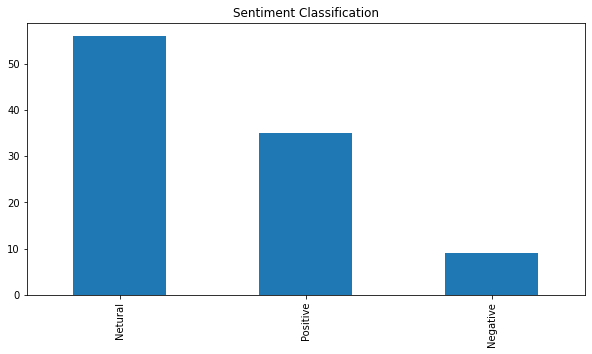

In [111]:
plt.figure(figsize=(10,5))
news.Sentiment.value_counts().plot(kind='bar')
plt.title('Sentiment Classification')
plt.show()


In [112]:
# Let's see the percentage of different sentiment's class

# creat
Df_Sentiment = pd.DataFrame(news.Sentiment.value_counts(normalize=True)*100)

# Calculating percentage
Df_Sentiment['Total'] = news.Sentiment.value_counts()

Df_Sentiment

,Sentiment,Total
Netural,56.0,56
Positive,35.0,35
Negative,9.0,9
